In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([5, 15, 80])

test_set = tfds.load('tf_flowers', split=test_split, as_supervised=True)
valid_set = tfds.load('tf_flowers', split=valid_split, as_supervised=True)
train_set, info = tfds.load('tf_flowers', split=train_split, as_supervised=True, with_info=True)

n_classes = info.features['label'].num_classes
class_names = info.features['label'].names

print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



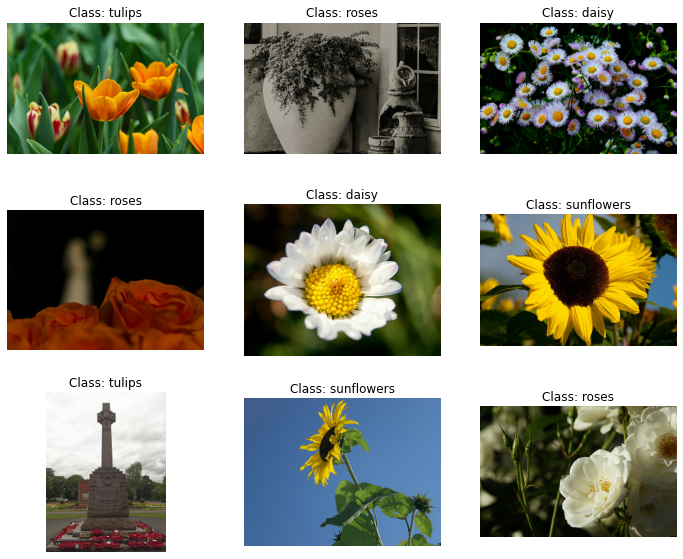

In [3]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

In [4]:
batch_size = 32

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)

In [5]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [6]:
for index, layer in enumerate(model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [7]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
92/92 [==============================] - 363s 4s/step - loss: 0.7750 - accuracy: 0.7696 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
92/92 [==============================] - 358s 4s/step - loss: 0.4084 - accuracy: 0.8737 - val_loss: 1.3269 - val_accuracy: 0.7495
Epoch 3/5
92/92 [==============================] - 356s 4s/step - loss: 0.2601 - accuracy: 0.9160 - val_loss: 1.0527 - val_accuracy: 0.7838
Epoch 4/5
92/92 [==============================] - 354s 4s/step - loss: 0.2061 - accuracy: 0.9311 - val_loss: 0.8011 - val_accuracy: 0.8036
Epoch 5/5
92/92 [==============================] - 355s 4s/step - loss: 0.1892 - accuracy: 0.9355 - val_loss: 1.0008 - val_accuracy: 0.7730


In [8]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

 # ideally, you would have more than 5 epochs...
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
92/92 [==============================] - 775s 8s/step - loss: 0.2433 - accuracy: 0.9181 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
92/92 [==============================] - 755s 8s/step - loss: 0.0529 - accuracy: 0.9850 - val_loss: 0.3303 - val_accuracy: 0.9153
Epoch 3/5
92/92 [==============================] - 753s 8s/step - loss: 0.0239 - accuracy: 0.9911 - val_loss: 0.3872 - val_accuracy: 0.9117
Epoch 4/5
92/92 [==============================] - 752s 8s/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.2843 - val_accuracy: 0.9189
Epoch 5/5
92/92 [==============================] - 753s 8s/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.2569 - val_accuracy: 0.9207
